In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import scipy
import pandas as pd
import arviz as az
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import NUTS, MCMC

az.style.use("arviz-darkgrid")
%matplotlib inline


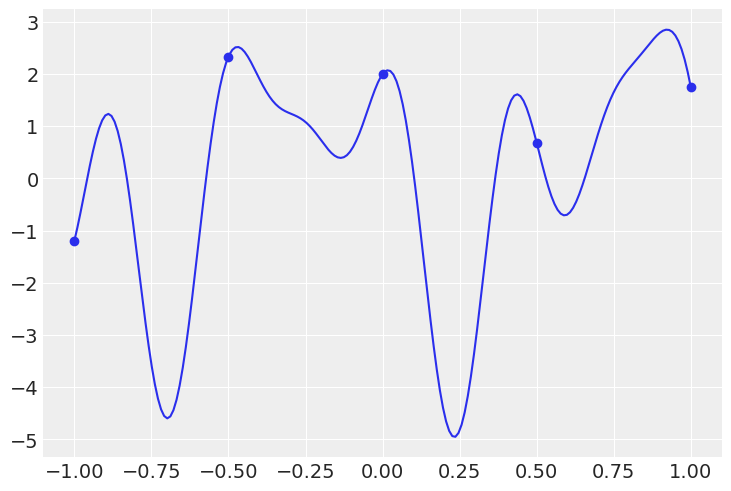

In [2]:
def f(x):
    return np.sin(20*x) + 2*np.cos(14*x) - 2*np.sin(6*x)

# data set
X = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1.0])
X_star = torch.linspace(-1, 1, 200)
y = f(X)
y_star = f(X_star)

plt.scatter(X, y)
plt.plot(X_star,y_star)

Warmup [1]:   0%|          | 0/125 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/125 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/125 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/125 [00:00, ?it/s]

c:\Users\Juliu\anaconda3\envs\OreL\lib\site-packages\arviz\data\io_pyro.py:153: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


\begin{tabular}{lrrrrrrrrr}
\toprule
{} &   mean &     sd &  hdi\_2.5\% &  hdi\_97.5\% &  mcse\_mean &  mcse\_sd &  ess\_bulk &  ess\_tail &  r\_hat \\
\midrule
kernel.lengthscale &  0.296 &  0.157 &     0.043 &      0.596 &      0.012 &    0.009 &     167.0 &     169.0 &   1.04 \\
kernel.variance    &  3.820 &  2.698 &     0.706 &      8.632 &      0.232 &    0.165 &     154.0 &     228.0 &   1.03 \\
\bottomrule
\end{tabular}



C:\Users\Juliu\AppData\Local\Temp\ipykernel_6248\837259783.py:34: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary_no_warm.to_latex(index=True))


Warmup [1]:   0%|          | 0/135 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/135 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/135 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/135 [00:00, ?it/s]

c:\Users\Juliu\anaconda3\envs\OreL\lib\site-packages\arviz\data\io_pyro.py:153: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
C:\Users\Juliu\AppData\Local\Temp\ipykernel_6248\837259783.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.to_latex(index=True))


\begin{tabular}{lrrrrrrrrr}
\toprule
{} &   mean &     sd &  hdi\_2.5\% &  hdi\_97.5\% &  mcse\_mean &  mcse\_sd &  ess\_bulk &  ess\_tail &  r\_hat \\
\midrule
kernel.lengthscale &  0.294 &  0.191 &     0.022 &      0.657 &      0.017 &    0.012 &     111.0 &     247.0 &   1.01 \\
kernel.variance    &  4.792 &  4.144 &     0.743 &     11.903 &      0.314 &    0.222 &     206.0 &     135.0 &   1.01 \\
\bottomrule
\end{tabular}



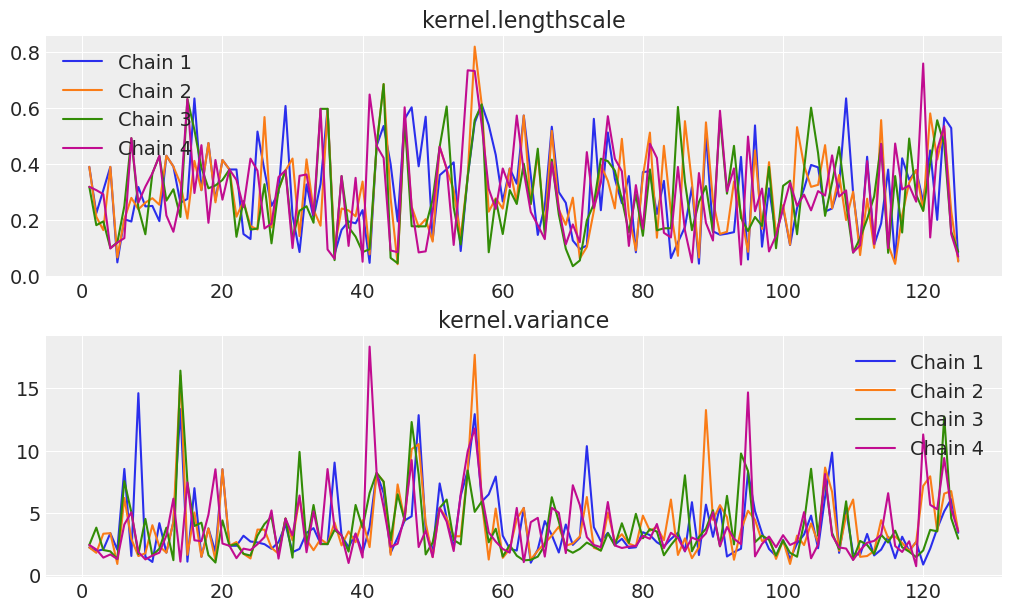

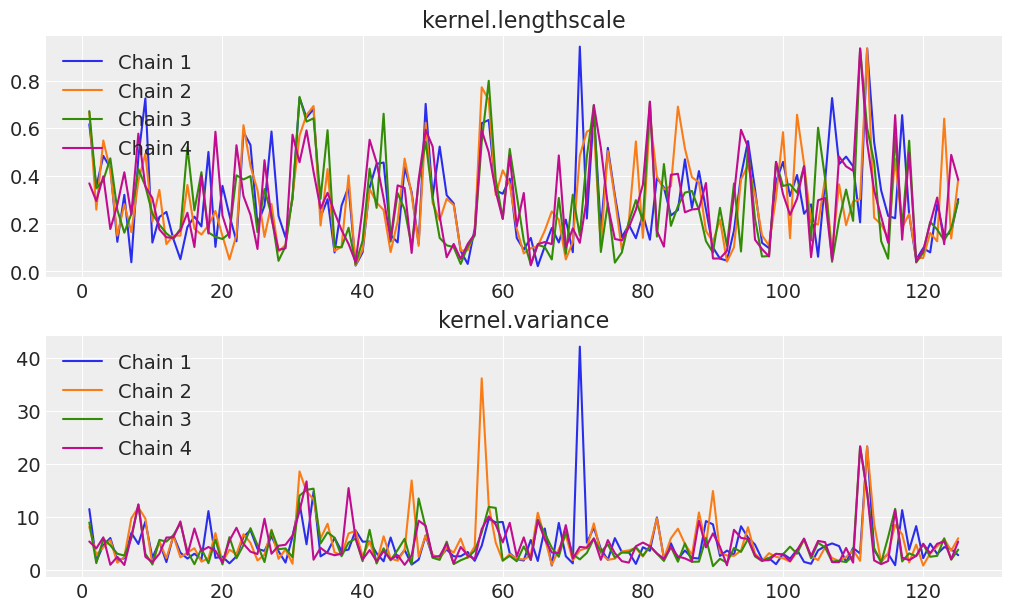

In [3]:
torch.manual_seed(2017)
pyro.clear_param_store()

# Assess convergence to stationary distribution using multiple chains
no_samples = 125
no_chains = 4
total_samples = no_samples * no_chains

kernel = gp.kernels.RBF(input_dim=1)

kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))

gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(10.0**(-4)))

nuts_kernel = NUTS(gpr.model)
mcmc = MCMC(nuts_kernel, num_samples=no_samples, num_chains=no_chains, warmup_steps=0)
mcmc.run()

posterior_ls_no_warm = torch.reshape(mcmc.get_samples()["kernel.lengthscale"], (no_samples, no_chains))
posterior_var_no_warm = torch.reshape(mcmc.get_samples()['kernel.variance'], (no_samples, no_chains))

fig, axs = plt.subplots(2, figsize=(10, 6))
for i in range(no_chains):
    axs[0].plot(np.arange(no_samples) + 1, posterior_ls_no_warm[:, i], label=f'Chain {i + 1}')
    axs[0].set_title('kernel.lengthscale')
    axs[0].legend()
    axs[1].plot(np.arange(no_samples) + 1, posterior_var_no_warm[:, i], label=f'Chain {i + 1}')
    axs[1].set_title('kernel.variance')
    axs[1].legend()

posterior_samples = az.from_pyro(mcmc)
summary_no_warm = az.summary(posterior_samples, hdi_prob=0.95)
print(summary_no_warm.to_latex(index=True))

# Sample 500 draws from the posterior using sufficient warm-up period based on diagnostics
kernel = gp.kernels.RBF(input_dim=1)

kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))

gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(10.0**(-4)))

nuts_kernel = NUTS(gpr.model)
mcmc = MCMC(nuts_kernel, num_samples=no_samples, num_chains=no_chains, warmup_steps=10)
mcmc.run()

posterior_ls = mcmc.get_samples()["kernel.lengthscale"]
posterior_var = mcmc.get_samples()['kernel.variance']

fig, axs = plt.subplots(2, figsize=(10, 6))
for i in range(no_chains):
    axs[0].plot(np.arange(no_samples) + 1, torch.reshape(posterior_ls, (no_samples, no_chains))[:, i], label=f'Chain {i + 1}')
    axs[0].set_title('kernel.lengthscale')
    axs[0].legend()
    axs[1].plot(np.arange(no_samples) + 1, torch.reshape(posterior_var, (no_samples, no_chains))[:, i], label=f'Chain {i + 1}')
    axs[1].set_title('kernel.variance')
    axs[1].legend()

posterior_samples = az.from_pyro(mcmc)
summary = az.summary(posterior_samples, hdi_prob=0.95)
print(summary.to_latex(index=True))

# az.plot_trace(mcmc.get_samples(), compact=False)
# az.plot_posterior(mcmc.get_samples(), hdi_prob=0.95)



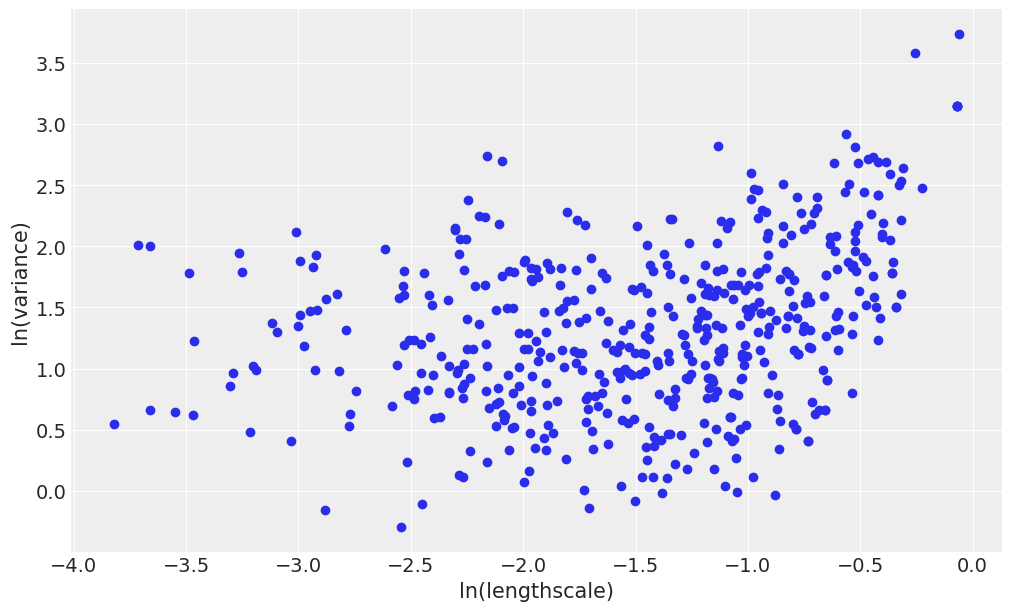

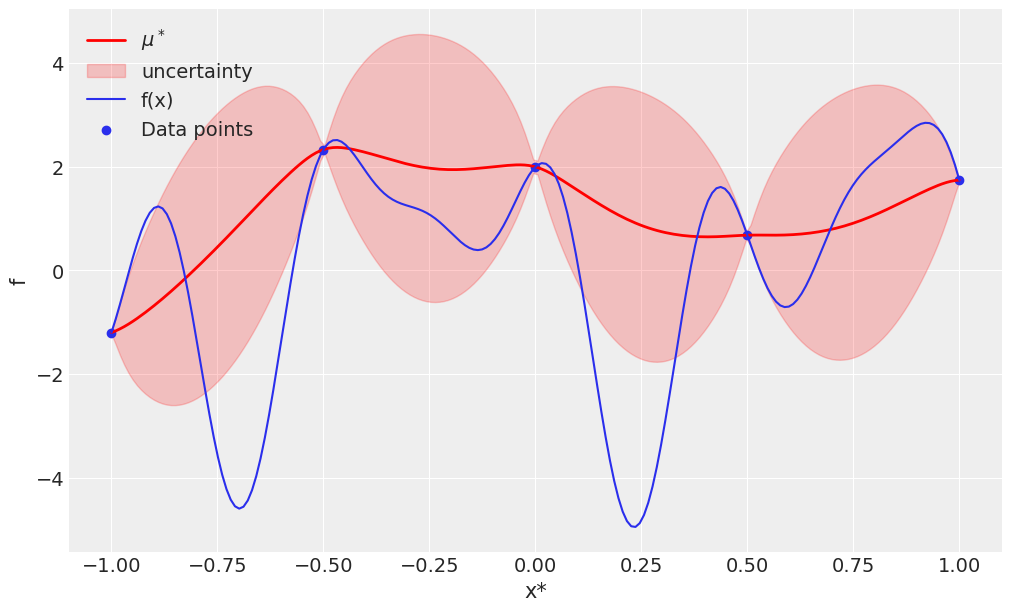

In [4]:
# Scatter plot on log-log scale of samples from posterior
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(torch.log(posterior_ls), torch.log(posterior_var))
plt.xlabel('ln(lengthscale)')
plt.ylabel('ln(variance)')

# Compute predictive mean and variance at x_stars
means = torch.zeros(len(X_star), no_samples)
covs  = torch.zeros(len(X_star), len(X_star), no_samples)

for i in range(no_samples):
    with torch.no_grad():
        gpr.kernel.lengthscale = posterior_ls[i]
        gpr.kernel.variance = posterior_var[i]
        means[:, i], covs[:, :, i] = gpr(X_star, full_cov=True, noiseless=False)

mean_post = means.mean(axis=1) # Posterior mean
cov_post = covs.mean(axis=2) # Posterior variance
sd = cov_post.diag().sqrt()  # standard deviation at each input point x

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(X_star.numpy(), mean_post.numpy(), "r", lw=2, label=r'$\mu^*$')  # plot the mean
ax.fill_between(
    X_star,  # plot the two-sigma uncertainty about the mean
    (mean_post - 2.0 * sd).numpy(),
    (mean_post + 2.0 * sd).numpy(),
    color="r",
    alpha=0.2,
    label='uncertainty'
)
ax.plot(X_star, y_star, label='f(x)')
ax.scatter(X, y, label='Data points')
plt.xlabel('x*')
plt.ylabel('f')
plt.legend()

### Bayesian Optimization

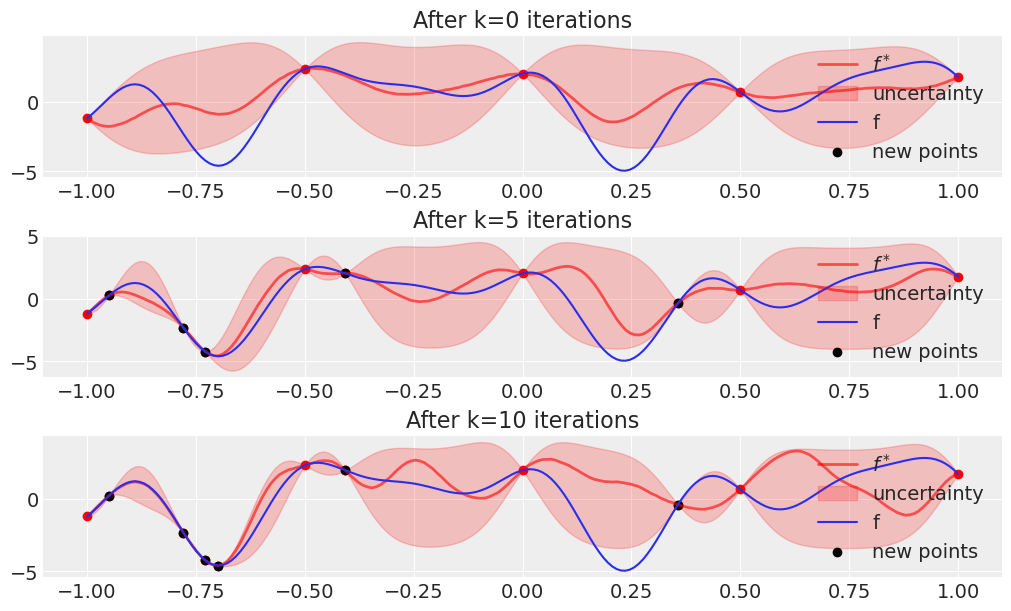

In [5]:
# Algorithm 1 - note we are supposed to plot f^*, and not mu^*
torch.manual_seed(2025)
T = 15
ks = (0, 5, 10)

def algorithm_1(X, y, X_star, y_star, T, sigma_s=(torch.tensor(0.), torch.tensor(2.0)), kernel_type='RBF', naive=True, print=False):
    
    k = 0
    no_iter = 0
    if print == True:
        fig, axs = plt.subplots(len(ks), 1, figsize=(10, 6))

    new_x_points = []
    new_y_points = []

    while k < T:

        pyro.clear_param_store()
        if kernel_type == 'RBF':
            kernel = gp.kernels.RBF(input_dim=1)
        else:
            kernel = gp.kernels.Matern32(input_dim=1)
            
        kernel.variance = pyro.nn.PyroSample(dist.LogNormal(sigma_s[0], sigma_s[1]))
        kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))

        gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(10.0**(-4)))
        nuts_kernel = NUTS(gpr.model)
        mcmc = MCMC(nuts_kernel, num_samples=1, disable_progbar=True, warmup_steps=10)

        while True:
            try:
                mcmc.run()
            except:
                pass
            else:
                break

        gpr.kernel.lengthscale = mcmc.get_samples()["kernel.lengthscale"][0]
        gpr.kernel.variance = mcmc.get_samples()['kernel.variance'][0]
        
        with torch.no_grad():
            mean, cov = gpr(X_star, full_cov=True, noiseless=False)

        # Draw from posterior
        try:
            f_star = torch.distributions.MultivariateNormal(mean, cov).sample()
        except: # if cov isn't positive definite, then resample
            continue

        if k in ks and print==True:
            sd = cov.diag().sqrt()  # standard deviation at each input point x
            axs[ks.index(k)].plot(X_star.numpy(), f_star, lw=2, c='r', alpha=0.6, label=f'$f^*$')  # plot the mean
            axs[ks.index(k)].set_title(f'After k={k} iterations')
            axs[ks.index(k)].fill_between(X_star,  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="r",
            alpha=0.2,
            label='uncertainty'
            )
            axs[ks.index(k)].plot(X_star, y_star, label='f')
            axs[ks.index(k)].scatter(X, y, color='red')
            axs[ks.index(k)].scatter(new_x_points, new_y_points, color='k', label='new points')
            axs[ks.index(k)].legend()
        
        # Find minimum and update
        if naive == True:
            idx_p = f_star.argmin()
            x_p = X_star[idx_p]
            f_x_p = f(x_p)
        else:
            idxs = torch.argsort(f_star)
            for idx in idxs:
                x_p = X_star[idx]
                f_x_p = f(x_p)
                if f_x_p not in y:
                    break  

        if f_x_p == min(y_star) and f_x_p not in y:
            no_iter = k # Number of iterations till minimum is found
            return f_x_p, no_iter

        if f_x_p not in y:
            x_p_idx = torch.searchsorted(X, x_p)
            X = torch.from_numpy(np.insert(X.numpy(), x_p_idx.numpy(), x_p.numpy()))
            y = torch.from_numpy(np.insert(y.numpy(), x_p_idx.numpy(), f_x_p))
            new_x_points.append(x_p)
            new_y_points.append(f_x_p)
    
        k += 1

    return min(y), no_iter

min_y, no_iter = algorithm_1(X, y, X_star, y_star, T, kernel_type='RBF', naive=True, print=True)

GP-LCB

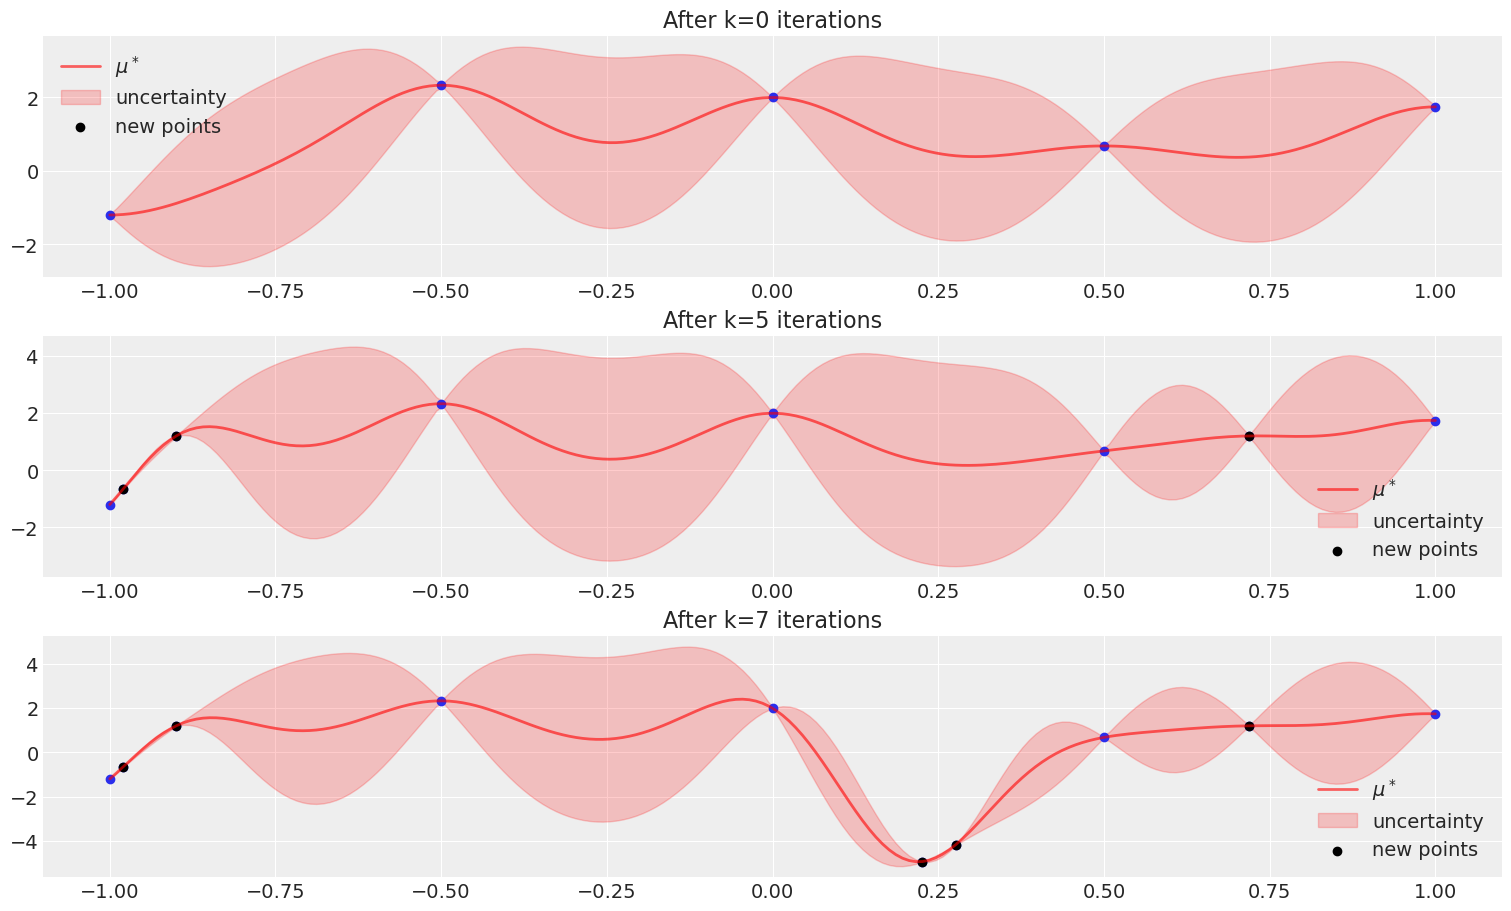

In [6]:
torch.manual_seed(2022)
T = 15
ks = (0, 5, 7)

def GP_LCB(X, y, X_star, y_star, T, sigma_s=(torch.tensor(0.), torch.tensor(2.0)), kappa=torch.tensor(1.), kernel_type='RBF', naive=True, print=False):

    no_iter = 0 
    beta = torch.sqrt(kappa * torch.log((torch.arange(T) + 1)))
    if print == True:
        fig, axs = plt.subplots(len(ks), 1, figsize=(15, 9))

    new_x_points = []
    new_y_points = []

    for k in range(T):

        pyro.clear_param_store()
        if kernel_type == 'RBF':
            kernel = gp.kernels.RBF(input_dim=1)
        else:
            kernel = gp.kernels.Matern32(input_dim=1)
            
        kernel.variance = pyro.nn.PyroSample(dist.LogNormal(sigma_s[0], sigma_s[1]))
        kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))

        gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(10.0**(-4)))
        nuts_kernel = NUTS(gpr.model)
        mcmc = MCMC(nuts_kernel, num_samples=1, disable_progbar=True, warmup_steps=10)
        try:
            mcmc.run()
        except: 
            mcmc.run()

        gpr.kernel.lengthscale = mcmc.get_samples()["kernel.lengthscale"][0]
        gpr.kernel.variance = mcmc.get_samples()['kernel.variance'][0]
        
        with torch.no_grad():
            mean, cov = gpr(X_star, full_cov=True, noiseless=False)

        if k in ks and print==True:
            sd = cov.diag().sqrt()  # standard deviation at each input point x
            axs[ks.index(k)].plot(X_star.numpy(), mean.numpy(), lw=2, c='r', alpha=0.6, label=f'$\mu^*$')  # plot the mean
            axs[ks.index(k)].set_title(f'After k={k} iterations')
            axs[ks.index(k)].fill_between(X_star,  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="r",
            alpha=0.2,
            label='uncertainty'
            )
            axs[ks.index(k)].scatter(X, y)
            axs[ks.index(k)].scatter(new_x_points, new_y_points, color='k', label='new points')
            axs[ks.index(k)].legend()

        # Use GP-LCB and update
        if naive == True:
            idx_p = (mean - beta[k] * cov.diag().sqrt()).argmin()
            x_p = X_star[idx_p]
            f_x_p = f(x_p)
        else:
            idxs = torch.argsort(mean - beta[k] * cov.diag().sqrt())
            for idx in idxs:
                x_p = X_star[idx]
                f_x_p = f(x_p)
                if f_x_p not in y:
                    break

        if f_x_p == min(y_star) and f_x_p not in y:
            no_iter = k # Number of iterations till minimum is found
            return f_x_p, no_iter

        if f_x_p not in y:
            x_p_idx = torch.searchsorted(X, x_p)
            X = torch.from_numpy(np.insert(X.numpy(), x_p_idx.numpy(), x_p.numpy()))
            y = torch.from_numpy(np.insert(y.numpy(), x_p_idx.numpy(), f_x_p))
            new_x_points.append(x_p)
            new_y_points.append(f_x_p)

    return min(y), no_iter

min_y, no_iter = GP_LCB(X, y, X_star, y_star, T, print=True)


### Performance examination and plots

C:\Users\Juliu\AppData\Local\Temp\ipykernel_6248\1630024755.py:34: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(final_df.groupby('algorithm', as_index=False)['Number of iterations'].mean().to_latex(index=False))


\begin{tabular}{lr}
\toprule
  algorithm &  Number of iterations \\
\midrule
 GP\_LCB\_M32 &              6.666667 \\
 GP\_LCB\_RBF &              6.333333 \\
alg\_1.1\_M32 &             11.533333 \\
alg\_1.1\_RBF &             12.366667 \\
  alg\_1\_RBF &             20.633333 \\
\bottomrule
\end{tabular}



C:\Users\Juliu\AppData\Local\Temp\ipykernel_6248\1630024755.py:34: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(final_df.groupby('algorithm', as_index=False)['Number of iterations'].mean().to_latex(index=False))


\begin{tabular}{lr}
\toprule
  algorithm &  Number of iterations \\
\midrule
 GP\_LCB\_M32 &              7.166667 \\
 GP\_LCB\_RBF &              6.266667 \\
alg\_1.1\_M32 &             14.566667 \\
alg\_1.1\_RBF &             13.033333 \\
  alg\_1\_RBF &             16.266667 \\
\bottomrule
\end{tabular}



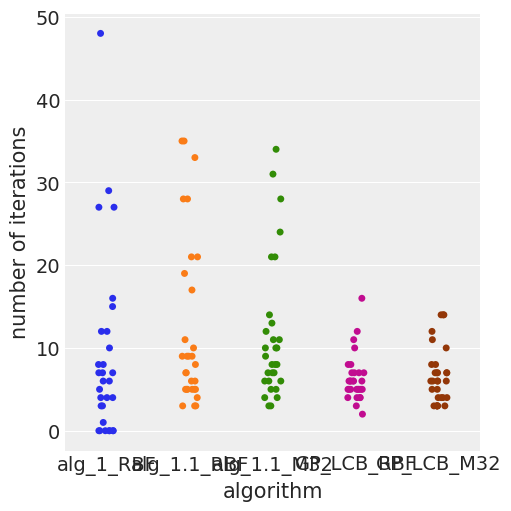

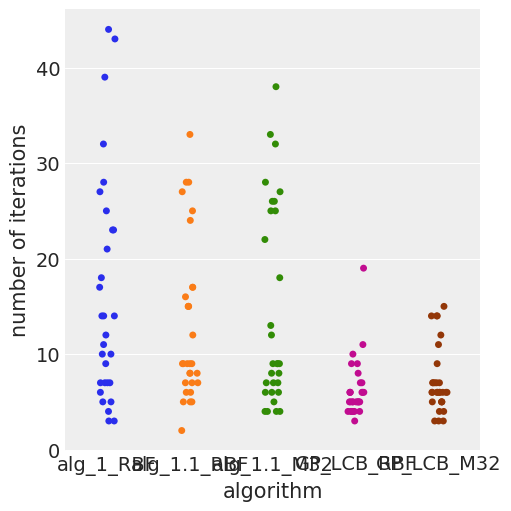

In [7]:
torch.manual_seed(1864)
# Initialization and parameters
T = 50 # Target iterations
n_reps = 30 # Number of repetitions to repeat Baeysian optimization algorithm
no_algos = 5 # Number of considered algorithms
no_iters = np.zeros((n_reps, no_algos))
sigma_s = (torch.tensor(0.), torch.tensor(2.0))
sigma_s_new = (torch.tensor(1.7), torch.tensor(0.3)) # New prior

def performance_plots(sigma_s):
    for i in range(n_reps):
        _, no_iters[i, 0] = algorithm_1(X, y, X_star, y_star, T, sigma_s=sigma_s, kernel_type='RBF', naive=True, print=False)
        _, no_iters[i, 1] = algorithm_1(X, y, X_star, y_star, T, sigma_s=sigma_s, kernel_type='RBF', naive=False, print=False)
        _, no_iters[i, 2] = algorithm_1(X, y, X_star, y_star, T, sigma_s=sigma_s, kernel_type='Matern', naive=False, print=False)
        _, no_iters[i, 3] = GP_LCB(X, y, X_star, y_star, T, sigma_s=sigma_s, kappa=torch.tensor(2.), kernel_type='RBF', naive=False, print=False)
        _, no_iters[i, 4] = GP_LCB(X, y, X_star, y_star, T, sigma_s=sigma_s, kappa=torch.tensor(2.), kernel_type='Matern', naive=False, print=False)

        # print(i)
        
    # Create pandas dataframe
    algorithms = ['alg_1_RBF', 'alg_1.1_RBF', 'alg_1.1_M32', 'GP_LCB_RBF', 'GP_LCB_M32']
    dfs = []
    for i, alg in enumerate(algorithms):
        df = pd.DataFrame({'Number of iterations': no_iters[:, i]})
        df['algorithm'] = alg
        dfs.append(df)

    final_df = pd.concat(dfs)

    ax = sns.catplot(x="algorithm", y="Number of iterations", data=final_df)
    ax.set(xlabel='algorithm', ylabel='number of iterations');

    final_df['Number of iterations'] = final_df['Number of iterations'].replace(0.0, 50)
    print(final_df.groupby('algorithm', as_index=False)['Number of iterations'].mean().to_latex(index=False))

performance_plots(sigma_s)
performance_plots(sigma_s_new)